In [ ]:
# !pip install tensorflow==2.8.0
# !pip install spektral==1.0.6

In [1]:
import os
import numpy as np

import spektral as spktrl
import tensorflow as tf
keras = tf.keras

from spektral.datasets import Citation, TUDataset
from spektral.data import SingleLoader, DisjointLoader
from spektral.data import Dataset, Graph

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
print(f'Using Spektral {spktrl.__version__}')
print(f'Using TensorFlow {tf.__version__}')
print('Physical GPUs:', tf.config.list_physical_devices('GPU'))

Using Spektral 1.0.6
Using TensorFlow 2.8.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Practical graph neural networks in Python with TensorFlow and Spektral

*PyData Berlin, 2022.04.13*

**Abstract**


Graph neural networks (GNNs) have become one of the hottest research topics in recent years. Their popularity is reinforced by hugely successful industry applications in social networks, biology, chemistry, neuroscience and many other areas. One of the main challenges faced by data scientists and researchers who want to apply graph networks in their work is that they require different data structures and a slightly different training approach than traditional deep learning models. During the workshop we’ll demonstrate how to implement graph neural networks, how to prepare your data and – finally – how to train a GNN model for node-level and graph-level tasks using Spektral and TensorFlow.



## 1. Node classification with functional API

We'll perform node classification using [CORA](https://relational.fit.cvut.cz/dataset/CORA) citation dataset

### 1.1 Get the data

In [3]:
# Load data
dataset = Citation("cora", normalize_x=True)

Pre-processing node features


C:\Users\aleks\anaconda3\envs\tf-spektral-minimal\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### 1.2 EDA

In [4]:
# Let's understand the adjacency matrix
dataset[0].a

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 10556 stored elements in Compressed Sparse Row format>

In [5]:
# Let's understand labels
dataset[0].y.shape

(2708, 7)

#### Exercise 1.2.1

Display the label of node 77. 


What is the label of this node?

In [7]:
# YOUR CODE HERE
dataset[0].y[76]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [8]:
# Let't understand features
dataset[0].x.shape

(2708, 1433)

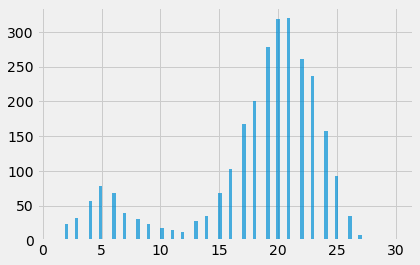

In [9]:
# Check the distribution of non-zero featueres over nodes
plt.hist((dataset[0].x > 0).sum(axis=1), alpha=.7, bins=100)
plt.show()

In [10]:
# Understand the masks 

# Training, val, test 
dataset.mask_tr, dataset.mask_va, dataset.mask_te

(array([ True,  True,  True, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ...,  True,  True,  True]))

#### Exercise 1.2.2

Compute the number of training, validation and test examples. 

What are these numbers?

In [11]:
# YOUR CODE HERE
print(f'Number of training examples: {dataset.mask_tr.sum()}')
print(f'Number of validation examples: {dataset.mask_va.sum()}')
print(f'Number of test examples: {dataset.mask_te.sum()}')

Number of training examples: 140
Number of validation examples: 500
Number of test examples: 1000


### 1.3 Prepare dataloaders

In [12]:
loader_tr = SingleLoader(dataset)
loader_va = SingleLoader(dataset)

### 1.4 Build and compile the model

#### 1.4.1 Build

In [13]:
# Inputs
in_x = keras.Input(shape=(dataset[0].x.shape[1],))
in_a = keras.Input(shape=(dataset[0].a.shape[0],), sparse=True)

In [14]:
# Add dropout on features (but not adjacency matrix)
dropout_1 = keras.layers.Dropout(.1)(in_x)

In [15]:
# Add GAT layer
gat_layer_1 = spktrl.layers.GATConv(
    channels=16,
    attn_heads=8,
    concat_heads=True,
    dropout_rate=.05,
    activation='selu',
    kernel_initializer='lecun_normal'
)([dropout_1, in_a])

In [16]:
# Add dropout
dropout_2 = keras.layers.Dropout(.1)(gat_layer_1)

In [17]:
# Final GAT layer
gat_out = spktrl.layers.GATConv(
    channels=dataset[0].n_labels,
    attn_heads=8,
    concat_heads=False,
    dropout_rate=.05,
    activation='softmax'
)([dropout_2, in_a])

In [18]:
# Enclose the layers in the model
model = keras.Model(inputs=[in_x, in_a], outputs=gat_out)

#### 1.4.2 Setup and compile

In [21]:
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10000  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

In [22]:
# Compile the model
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gat_conv (GATConv)             (None, 128)          183808      ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

C:\Users\aleks\anaconda3\envs\tf-spektral-minimal\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### 1.4.3 Train

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=PATIENCE//2, min_lr=5e-6, factor=.9)
]

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10000
1/1 [==============================] - 6s 6s/step - loss: 5269.5791 - acc: 0.1488 - val_loss: 5251.5698 - val_acc: 0.3021 - lr: 0.0050
Epoch 2/10000
1/1 [==============================] - 0s 192ms/step - loss: 5251.5752 - acc: 0.3021 - val_loss: 5224.3330 - val_acc: 0.3021 - lr: 0.0050
Epoch 3/10000
1/1 [==============================] - 0s 35ms/step - loss: 5224.2803 - acc: 0.3021 - val_loss: 5186.9009 - val_acc: 0.3021 - lr: 0.0050
Epoch 4/10000
1/1 [==============================] - 0s 45ms/step - loss: 5187.0742 - acc: 0.3021 - val_loss: 5139.6865 - val_acc: 0.3021 - lr: 0.0050
Epoch 5/10000
1/1 [==============================] - 0s 30ms/step - loss: 5139.3828 - acc: 0.3021 - val_loss: 5084.0098 - val_acc: 0.3021 - lr: 0.0050
Epoch 6/10000
1/1 [==============================] - 0s 40ms/step - loss: 5084.6245 - acc: 0.3021 - val_loss: 5021.9956 - val_acc: 0.3021 - lr: 0.0050
Epoch 7/10000
1/1 [==============================] - 0s 42ms/step - loss: 5021.7363 - acc: 0.30

Epoch 55/10000
1/1 [==============================] - 0s 38ms/step - loss: 1235.7917 - acc: 0.8855 - val_loss: 1180.0026 - val_acc: 0.8903 - lr: 0.0050
Epoch 56/10000
1/1 [==============================] - 0s 30ms/step - loss: 1192.7092 - acc: 0.8914 - val_loss: 1143.9248 - val_acc: 0.8922 - lr: 0.0050
Epoch 57/10000
1/1 [==============================] - 0s 48ms/step - loss: 1166.3488 - acc: 0.8907 - val_loss: 1109.7523 - val_acc: 0.8936 - lr: 0.0050
Epoch 58/10000
1/1 [==============================] - 0s 30ms/step - loss: 1141.1881 - acc: 0.8892 - val_loss: 1077.3516 - val_acc: 0.8936 - lr: 0.0050
Epoch 59/10000
1/1 [==============================] - 0s 40ms/step - loss: 1095.5416 - acc: 0.8944 - val_loss: 1046.7091 - val_acc: 0.8970 - lr: 0.0050
Epoch 60/10000
1/1 [==============================] - 0s 33ms/step - loss: 1066.6796 - acc: 0.8948 - val_loss: 1017.8554 - val_acc: 0.9007 - lr: 0.0050
Epoch 61/10000
1/1 [==============================] - 0s 40ms/step - loss: 1037.0337 - a

1/1 [==============================] - 0s 30ms/step - loss: 536.1606 - acc: 0.9357 - val_loss: 500.0695 - val_acc: 0.9413 - lr: 0.0050
Epoch 110/10000
1/1 [==============================] - 0s 40ms/step - loss: 529.6281 - acc: 0.9350 - val_loss: 495.2888 - val_acc: 0.9417 - lr: 0.0050
Epoch 111/10000
1/1 [==============================] - 0s 40ms/step - loss: 523.3282 - acc: 0.9380 - val_loss: 490.6259 - val_acc: 0.9431 - lr: 0.0050
Epoch 112/10000
1/1 [==============================] - 0s 32ms/step - loss: 521.3621 - acc: 0.9376 - val_loss: 485.9068 - val_acc: 0.9439 - lr: 0.0050
Epoch 113/10000
1/1 [==============================] - 0s 30ms/step - loss: 506.7145 - acc: 0.9387 - val_loss: 481.3802 - val_acc: 0.9428 - lr: 0.0050
Epoch 114/10000
1/1 [==============================] - 0s 30ms/step - loss: 506.4189 - acc: 0.9354 - val_loss: 477.1049 - val_acc: 0.9431 - lr: 0.0050
Epoch 115/10000
1/1 [==============================] - 0s 40ms/step - loss: 508.0590 - acc: 0.9365 - val_loss:

1/1 [==============================] - 0s 30ms/step - loss: 335.9224 - acc: 0.9561 - val_loss: 305.5936 - val_acc: 0.9638 - lr: 0.0050
Epoch 164/10000
1/1 [==============================] - 0s 32ms/step - loss: 348.2623 - acc: 0.9575 - val_loss: 302.5217 - val_acc: 0.9634 - lr: 0.0050
Epoch 165/10000
1/1 [==============================] - 0s 33ms/step - loss: 326.9847 - acc: 0.9597 - val_loss: 299.5444 - val_acc: 0.9638 - lr: 0.0050
Epoch 166/10000
1/1 [==============================] - 0s 40ms/step - loss: 338.4331 - acc: 0.9605 - val_loss: 296.9094 - val_acc: 0.9649 - lr: 0.0050
Epoch 167/10000
1/1 [==============================] - 0s 40ms/step - loss: 334.5098 - acc: 0.9572 - val_loss: 294.3071 - val_acc: 0.9649 - lr: 0.0050
Epoch 168/10000
1/1 [==============================] - 0s 31ms/step - loss: 332.8525 - acc: 0.9583 - val_loss: 291.6598 - val_acc: 0.9657 - lr: 0.0050
Epoch 169/10000
1/1 [==============================] - 0s 30ms/step - loss: 324.8434 - acc: 0.9597 - val_loss:

1/1 [==============================] - 0s 36ms/step - loss: 237.5294 - acc: 0.9730 - val_loss: 188.7911 - val_acc: 0.9812 - lr: 0.0050
Epoch 218/10000
1/1 [==============================] - 0s 40ms/step - loss: 223.9405 - acc: 0.9738 - val_loss: 187.2702 - val_acc: 0.9812 - lr: 0.0050
Epoch 219/10000
1/1 [==============================] - 0s 35ms/step - loss: 226.2333 - acc: 0.9749 - val_loss: 185.6325 - val_acc: 0.9815 - lr: 0.0050
Epoch 220/10000
1/1 [==============================] - 0s 30ms/step - loss: 222.0777 - acc: 0.9742 - val_loss: 183.9231 - val_acc: 0.9819 - lr: 0.0050
Epoch 221/10000
1/1 [==============================] - 0s 45ms/step - loss: 232.7361 - acc: 0.9708 - val_loss: 182.2099 - val_acc: 0.9819 - lr: 0.0050
Epoch 222/10000
1/1 [==============================] - 0s 36ms/step - loss: 220.0986 - acc: 0.9742 - val_loss: 180.6891 - val_acc: 0.9826 - lr: 0.0050
Epoch 223/10000
1/1 [==============================] - 0s 44ms/step - loss: 215.6416 - acc: 0.9753 - val_loss:

1/1 [==============================] - 0s 39ms/step - loss: 179.6108 - acc: 0.9786 - val_loss: 127.1408 - val_acc: 0.9878 - lr: 0.0050
Epoch 272/10000
1/1 [==============================] - 0s 39ms/step - loss: 174.7443 - acc: 0.9801 - val_loss: 126.0254 - val_acc: 0.9874 - lr: 0.0050
Epoch 273/10000
1/1 [==============================] - 0s 37ms/step - loss: 170.8768 - acc: 0.9801 - val_loss: 125.2324 - val_acc: 0.9871 - lr: 0.0050
Epoch 274/10000
1/1 [==============================] - 0s 40ms/step - loss: 171.4101 - acc: 0.9815 - val_loss: 124.7539 - val_acc: 0.9874 - lr: 0.0050
Epoch 275/10000
1/1 [==============================] - 0s 39ms/step - loss: 163.1806 - acc: 0.9826 - val_loss: 123.9596 - val_acc: 0.9874 - lr: 0.0050
Epoch 276/10000
1/1 [==============================] - 0s 40ms/step - loss: 165.3436 - acc: 0.9819 - val_loss: 122.8985 - val_acc: 0.9878 - lr: 0.0050
Epoch 277/10000
1/1 [==============================] - 0s 31ms/step - loss: 167.6024 - acc: 0.9808 - val_loss:

1/1 [==============================] - 0s 36ms/step - loss: 145.3651 - acc: 0.9823 - val_loss: 90.3746 - val_acc: 0.9897 - lr: 0.0050
Epoch 326/10000
1/1 [==============================] - 0s 40ms/step - loss: 125.9869 - acc: 0.9834 - val_loss: 89.3407 - val_acc: 0.9893 - lr: 0.0050
Epoch 327/10000
1/1 [==============================] - 0s 32ms/step - loss: 125.0608 - acc: 0.9856 - val_loss: 88.4012 - val_acc: 0.9908 - lr: 0.0050
Epoch 328/10000
1/1 [==============================] - 0s 30ms/step - loss: 136.7539 - acc: 0.9823 - val_loss: 87.6605 - val_acc: 0.9911 - lr: 0.0050
Epoch 329/10000
1/1 [==============================] - 0s 31ms/step - loss: 135.6365 - acc: 0.9838 - val_loss: 87.0920 - val_acc: 0.9904 - lr: 0.0050
Epoch 330/10000
1/1 [==============================] - 0s 36ms/step - loss: 130.6778 - acc: 0.9841 - val_loss: 86.7628 - val_acc: 0.9904 - lr: 0.0050
Epoch 331/10000
1/1 [==============================] - 0s 30ms/step - loss: 123.7056 - acc: 0.9845 - val_loss: 86.78

Epoch 380/10000
1/1 [==============================] - 0s 34ms/step - loss: 105.2599 - acc: 0.9867 - val_loss: 64.8906 - val_acc: 0.9930 - lr: 0.0050
Epoch 381/10000
1/1 [==============================] - 0s 39ms/step - loss: 99.1428 - acc: 0.9908 - val_loss: 64.4476 - val_acc: 0.9934 - lr: 0.0050
Epoch 382/10000
1/1 [==============================] - 0s 30ms/step - loss: 105.7502 - acc: 0.9878 - val_loss: 63.8406 - val_acc: 0.9930 - lr: 0.0050
Epoch 383/10000
1/1 [==============================] - 0s 43ms/step - loss: 103.1762 - acc: 0.9886 - val_loss: 63.6310 - val_acc: 0.9934 - lr: 0.0050
Epoch 384/10000
1/1 [==============================] - 0s 32ms/step - loss: 109.8737 - acc: 0.9863 - val_loss: 63.5295 - val_acc: 0.9937 - lr: 0.0050
Epoch 385/10000
1/1 [==============================] - 0s 30ms/step - loss: 93.9433 - acc: 0.9897 - val_loss: 63.3478 - val_acc: 0.9937 - lr: 0.0050
Epoch 386/10000
1/1 [==============================] - 0s 40ms/step - loss: 103.0110 - acc: 0.9874 - v

Epoch 435/10000
1/1 [==============================] - 0s 35ms/step - loss: 79.2856 - acc: 0.9915 - val_loss: 48.4700 - val_acc: 0.9956 - lr: 0.0050
Epoch 436/10000
1/1 [==============================] - 0s 40ms/step - loss: 91.4640 - acc: 0.9904 - val_loss: 48.3158 - val_acc: 0.9956 - lr: 0.0050
Epoch 437/10000
1/1 [==============================] - 0s 36ms/step - loss: 85.2482 - acc: 0.9908 - val_loss: 47.9150 - val_acc: 0.9956 - lr: 0.0050
Epoch 438/10000
1/1 [==============================] - 0s 27ms/step - loss: 84.1563 - acc: 0.9908 - val_loss: 47.6782 - val_acc: 0.9959 - lr: 0.0050
Epoch 439/10000
1/1 [==============================] - 0s 44ms/step - loss: 76.6561 - acc: 0.9908 - val_loss: 47.4568 - val_acc: 0.9959 - lr: 0.0050
Epoch 440/10000
1/1 [==============================] - 0s 34ms/step - loss: 84.9972 - acc: 0.9911 - val_loss: 47.1510 - val_acc: 0.9952 - lr: 0.0050
Epoch 441/10000
1/1 [==============================] - 0s 34ms/step - loss: 89.2508 - acc: 0.9897 - val_lo

Epoch 490/10000
1/1 [==============================] - 0s 32ms/step - loss: 71.1991 - acc: 0.9937 - val_loss: 38.1714 - val_acc: 0.9959 - lr: 0.0050
Epoch 491/10000
1/1 [==============================] - 0s 30ms/step - loss: 64.3230 - acc: 0.9937 - val_loss: 37.9241 - val_acc: 0.9959 - lr: 0.0050
Epoch 492/10000
1/1 [==============================] - 0s 44ms/step - loss: 73.5699 - acc: 0.9919 - val_loss: 37.5870 - val_acc: 0.9963 - lr: 0.0050
Epoch 493/10000
1/1 [==============================] - 0s 35ms/step - loss: 70.2121 - acc: 0.9922 - val_loss: 37.2738 - val_acc: 0.9963 - lr: 0.0050
Epoch 494/10000
1/1 [==============================] - 0s 28ms/step - loss: 77.5345 - acc: 0.9904 - val_loss: 36.9351 - val_acc: 0.9963 - lr: 0.0050
Epoch 495/10000
1/1 [==============================] - 0s 34ms/step - loss: 62.9963 - acc: 0.9919 - val_loss: 36.6790 - val_acc: 0.9967 - lr: 0.0050
Epoch 496/10000
1/1 [==============================] - 0s 31ms/step - loss: 66.2844 - acc: 0.9934 - val_lo

Epoch 545/10000
1/1 [==============================] - 0s 32ms/step - loss: 64.9183 - acc: 0.9922 - val_loss: 30.2951 - val_acc: 0.9963 - lr: 0.0050
Epoch 546/10000
1/1 [==============================] - 0s 39ms/step - loss: 58.4230 - acc: 0.9934 - val_loss: 30.2781 - val_acc: 0.9963 - lr: 0.0050
Epoch 547/10000
1/1 [==============================] - 0s 31ms/step - loss: 52.7462 - acc: 0.9941 - val_loss: 30.2847 - val_acc: 0.9963 - lr: 0.0050
Epoch 548/10000
1/1 [==============================] - 0s 32ms/step - loss: 59.7960 - acc: 0.9915 - val_loss: 30.2867 - val_acc: 0.9963 - lr: 0.0050
Epoch 549/10000
1/1 [==============================] - 0s 37ms/step - loss: 54.3257 - acc: 0.9948 - val_loss: 30.2411 - val_acc: 0.9963 - lr: 0.0050
Epoch 550/10000
1/1 [==============================] - 0s 40ms/step - loss: 59.9647 - acc: 0.9937 - val_loss: 30.1718 - val_acc: 0.9967 - lr: 0.0050
Epoch 551/10000
1/1 [==============================] - 0s 37ms/step - loss: 60.2131 - acc: 0.9941 - val_lo

Epoch 600/10000
1/1 [==============================] - 0s 34ms/step - loss: 47.9665 - acc: 0.9952 - val_loss: 25.1412 - val_acc: 0.9970 - lr: 0.0050
Epoch 601/10000
1/1 [==============================] - 0s 41ms/step - loss: 50.9657 - acc: 0.9930 - val_loss: 25.2062 - val_acc: 0.9967 - lr: 0.0050
Epoch 602/10000
1/1 [==============================] - 0s 36ms/step - loss: 49.9306 - acc: 0.9952 - val_loss: 25.2627 - val_acc: 0.9967 - lr: 0.0050
Epoch 603/10000
1/1 [==============================] - 0s 30ms/step - loss: 56.5848 - acc: 0.9934 - val_loss: 25.2161 - val_acc: 0.9967 - lr: 0.0050
Epoch 604/10000
1/1 [==============================] - 0s 40ms/step - loss: 45.0000 - acc: 0.9956 - val_loss: 25.1278 - val_acc: 0.9967 - lr: 0.0050
Epoch 605/10000
1/1 [==============================] - 0s 40ms/step - loss: 52.3607 - acc: 0.9952 - val_loss: 25.0268 - val_acc: 0.9970 - lr: 0.0050
Epoch 606/10000
1/1 [==============================] - 0s 41ms/step - loss: 42.9891 - acc: 0.9952 - val_lo

Epoch 655/10000
1/1 [==============================] - 0s 30ms/step - loss: 41.1412 - acc: 0.9959 - val_loss: 22.4411 - val_acc: 0.9974 - lr: 0.0050
Epoch 656/10000
1/1 [==============================] - 0s 40ms/step - loss: 44.9831 - acc: 0.9948 - val_loss: 22.2219 - val_acc: 0.9974 - lr: 0.0050
Epoch 657/10000
1/1 [==============================] - 0s 32ms/step - loss: 51.7708 - acc: 0.9948 - val_loss: 21.9016 - val_acc: 0.9974 - lr: 0.0050
Epoch 658/10000
1/1 [==============================] - 0s 30ms/step - loss: 47.9388 - acc: 0.9948 - val_loss: 21.7368 - val_acc: 0.9974 - lr: 0.0050
Epoch 659/10000
1/1 [==============================] - 0s 41ms/step - loss: 41.3173 - acc: 0.9952 - val_loss: 21.7463 - val_acc: 0.9974 - lr: 0.0050
Epoch 660/10000
1/1 [==============================] - 0s 32ms/step - loss: 41.5250 - acc: 0.9956 - val_loss: 21.8379 - val_acc: 0.9974 - lr: 0.0050
Epoch 661/10000
1/1 [==============================] - 0s 35ms/step - loss: 39.6673 - acc: 0.9952 - val_lo

Epoch 710/10000
1/1 [==============================] - 0s 36ms/step - loss: 38.3927 - acc: 0.9956 - val_loss: 18.8202 - val_acc: 0.9978 - lr: 0.0050
Epoch 711/10000
1/1 [==============================] - 0s 35ms/step - loss: 38.1074 - acc: 0.9952 - val_loss: 18.7774 - val_acc: 0.9978 - lr: 0.0050
Epoch 712/10000
1/1 [==============================] - 0s 33ms/step - loss: 38.1604 - acc: 0.9956 - val_loss: 18.8171 - val_acc: 0.9978 - lr: 0.0050
Epoch 713/10000
1/1 [==============================] - 0s 34ms/step - loss: 35.5449 - acc: 0.9963 - val_loss: 18.8897 - val_acc: 0.9970 - lr: 0.0050
Epoch 714/10000
1/1 [==============================] - 0s 33ms/step - loss: 39.6141 - acc: 0.9948 - val_loss: 18.9739 - val_acc: 0.9974 - lr: 0.0050
Epoch 715/10000
1/1 [==============================] - 0s 34ms/step - loss: 40.7819 - acc: 0.9959 - val_loss: 19.0087 - val_acc: 0.9970 - lr: 0.0050
Epoch 716/10000
1/1 [==============================] - 0s 34ms/step - loss: 35.0536 - acc: 0.9956 - val_lo

Epoch 765/10000
1/1 [==============================] - 0s 36ms/step - loss: 35.0409 - acc: 0.9956 - val_loss: 16.9653 - val_acc: 0.9974 - lr: 0.0050
Epoch 766/10000
1/1 [==============================] - 0s 40ms/step - loss: 29.5702 - acc: 0.9970 - val_loss: 16.9050 - val_acc: 0.9978 - lr: 0.0050
Epoch 767/10000
1/1 [==============================] - 0s 36ms/step - loss: 35.8463 - acc: 0.9967 - val_loss: 16.8694 - val_acc: 0.9978 - lr: 0.0050
Epoch 768/10000
1/1 [==============================] - 0s 30ms/step - loss: 32.2402 - acc: 0.9956 - val_loss: 16.8376 - val_acc: 0.9978 - lr: 0.0050
Epoch 769/10000
1/1 [==============================] - 0s 40ms/step - loss: 36.0083 - acc: 0.9952 - val_loss: 16.7828 - val_acc: 0.9978 - lr: 0.0050
Epoch 770/10000
1/1 [==============================] - 0s 36ms/step - loss: 36.0081 - acc: 0.9952 - val_loss: 16.7367 - val_acc: 0.9978 - lr: 0.0050
Epoch 771/10000
1/1 [==============================] - 0s 30ms/step - loss: 35.5555 - acc: 0.9959 - val_lo

Epoch 820/10000
1/1 [==============================] - 0s 32ms/step - loss: 30.2647 - acc: 0.9959 - val_loss: 15.4641 - val_acc: 0.9974 - lr: 0.0050
Epoch 821/10000
1/1 [==============================] - 0s 30ms/step - loss: 38.3082 - acc: 0.9956 - val_loss: 15.3953 - val_acc: 0.9974 - lr: 0.0050
Epoch 822/10000
1/1 [==============================] - 0s 45ms/step - loss: 30.7135 - acc: 0.9963 - val_loss: 15.3655 - val_acc: 0.9974 - lr: 0.0050
Epoch 823/10000
1/1 [==============================] - 0s 35ms/step - loss: 28.5737 - acc: 0.9963 - val_loss: 15.3560 - val_acc: 0.9974 - lr: 0.0050
Epoch 824/10000
1/1 [==============================] - 0s 40ms/step - loss: 27.8824 - acc: 0.9956 - val_loss: 15.3315 - val_acc: 0.9974 - lr: 0.0050
Epoch 825/10000
1/1 [==============================] - 0s 35ms/step - loss: 27.7115 - acc: 0.9970 - val_loss: 15.2980 - val_acc: 0.9974 - lr: 0.0050
Epoch 826/10000
1/1 [==============================] - 0s 30ms/step - loss: 31.2444 - acc: 0.9967 - val_lo

Epoch 875/10000
1/1 [==============================] - 0s 38ms/step - loss: 34.7373 - acc: 0.9945 - val_loss: 14.1430 - val_acc: 0.9978 - lr: 0.0050
Epoch 876/10000
1/1 [==============================] - 0s 30ms/step - loss: 26.1276 - acc: 0.9963 - val_loss: 14.1563 - val_acc: 0.9982 - lr: 0.0050
Epoch 877/10000
1/1 [==============================] - 0s 40ms/step - loss: 23.2801 - acc: 0.9970 - val_loss: 14.1793 - val_acc: 0.9982 - lr: 0.0050
Epoch 878/10000
1/1 [==============================] - 0s 40ms/step - loss: 27.0384 - acc: 0.9967 - val_loss: 14.1856 - val_acc: 0.9982 - lr: 0.0050
Epoch 879/10000
1/1 [==============================] - 0s 30ms/step - loss: 26.4494 - acc: 0.9974 - val_loss: 14.1533 - val_acc: 0.9982 - lr: 0.0050
Epoch 880/10000
1/1 [==============================] - 0s 30ms/step - loss: 33.1179 - acc: 0.9956 - val_loss: 14.1209 - val_acc: 0.9982 - lr: 0.0050
Epoch 881/10000
1/1 [==============================] - 0s 33ms/step - loss: 22.6140 - acc: 0.9978 - val_lo

Epoch 930/10000
1/1 [==============================] - 0s 30ms/step - loss: 27.3900 - acc: 0.9967 - val_loss: 13.1044 - val_acc: 0.9982 - lr: 0.0045
Epoch 931/10000
1/1 [==============================] - 0s 42ms/step - loss: 26.2922 - acc: 0.9959 - val_loss: 13.1492 - val_acc: 0.9982 - lr: 0.0045
Epoch 932/10000
1/1 [==============================] - 0s 32ms/step - loss: 28.7257 - acc: 0.9959 - val_loss: 13.1555 - val_acc: 0.9982 - lr: 0.0045
Epoch 933/10000
1/1 [==============================] - 0s 30ms/step - loss: 31.6910 - acc: 0.9963 - val_loss: 13.1132 - val_acc: 0.9982 - lr: 0.0045
Epoch 934/10000
1/1 [==============================] - 0s 40ms/step - loss: 33.3392 - acc: 0.9967 - val_loss: 13.0544 - val_acc: 0.9982 - lr: 0.0045
Epoch 935/10000
1/1 [==============================] - 0s 40ms/step - loss: 27.5418 - acc: 0.9974 - val_loss: 12.9910 - val_acc: 0.9982 - lr: 0.0045
Epoch 936/10000
1/1 [==============================] - 0s 36ms/step - loss: 25.1552 - acc: 0.9963 - val_lo

Epoch 985/10000
1/1 [==============================] - 0s 40ms/step - loss: 24.8675 - acc: 0.9963 - val_loss: 12.1749 - val_acc: 0.9982 - lr: 0.0045
Epoch 986/10000
1/1 [==============================] - 0s 40ms/step - loss: 23.5491 - acc: 0.9963 - val_loss: 12.1241 - val_acc: 0.9982 - lr: 0.0045
Epoch 987/10000
1/1 [==============================] - 0s 38ms/step - loss: 23.7442 - acc: 0.9978 - val_loss: 12.1226 - val_acc: 0.9982 - lr: 0.0045
Epoch 988/10000
1/1 [==============================] - 0s 30ms/step - loss: 21.5903 - acc: 0.9974 - val_loss: 12.1392 - val_acc: 0.9982 - lr: 0.0045
Epoch 989/10000
1/1 [==============================] - 0s 35ms/step - loss: 27.6461 - acc: 0.9970 - val_loss: 12.1865 - val_acc: 0.9982 - lr: 0.0045
Epoch 990/10000
1/1 [==============================] - 0s 36ms/step - loss: 26.6264 - acc: 0.9963 - val_loss: 12.2144 - val_acc: 0.9982 - lr: 0.0045
Epoch 991/10000
1/1 [==============================] - 0s 35ms/step - loss: 24.5324 - acc: 0.9970 - val_lo

Epoch 1040/10000
1/1 [==============================] - 0s 33ms/step - loss: 23.3035 - acc: 0.9967 - val_loss: 11.8295 - val_acc: 0.9978 - lr: 0.0040
Epoch 1041/10000
1/1 [==============================] - 0s 35ms/step - loss: 22.3381 - acc: 0.9970 - val_loss: 11.8095 - val_acc: 0.9982 - lr: 0.0040
Epoch 1042/10000
1/1 [==============================] - 0s 41ms/step - loss: 22.2769 - acc: 0.9974 - val_loss: 11.7346 - val_acc: 0.9982 - lr: 0.0040
Epoch 1043/10000
1/1 [==============================] - 0s 37ms/step - loss: 21.3945 - acc: 0.9967 - val_loss: 11.6696 - val_acc: 0.9982 - lr: 0.0040
Epoch 1044/10000
1/1 [==============================] - 0s 40ms/step - loss: 23.9872 - acc: 0.9970 - val_loss: 11.5831 - val_acc: 0.9982 - lr: 0.0040
Epoch 1045/10000
1/1 [==============================] - 0s 37ms/step - loss: 18.6944 - acc: 0.9978 - val_loss: 11.5310 - val_acc: 0.9978 - lr: 0.0040
Epoch 1046/10000
1/1 [==============================] - 0s 40ms/step - loss: 21.6300 - acc: 0.9963 -

1/1 [==============================] - 0s 32ms/step - loss: 22.6376 - acc: 0.9963 - val_loss: 11.1818 - val_acc: 0.9982 - lr: 0.0036
Epoch 1095/10000
1/1 [==============================] - 0s 39ms/step - loss: 21.2163 - acc: 0.9978 - val_loss: 11.1304 - val_acc: 0.9982 - lr: 0.0036
Epoch 1096/10000
1/1 [==============================] - 0s 42ms/step - loss: 20.9929 - acc: 0.9974 - val_loss: 11.0712 - val_acc: 0.9982 - lr: 0.0036
Epoch 1097/10000
1/1 [==============================] - 0s 39ms/step - loss: 22.2453 - acc: 0.9963 - val_loss: 11.0424 - val_acc: 0.9982 - lr: 0.0036
Epoch 1098/10000
1/1 [==============================] - 0s 42ms/step - loss: 22.1862 - acc: 0.9963 - val_loss: 11.0350 - val_acc: 0.9982 - lr: 0.0036
Epoch 1099/10000
1/1 [==============================] - 0s 39ms/step - loss: 23.0925 - acc: 0.9970 - val_loss: 11.0638 - val_acc: 0.9982 - lr: 0.0036
Epoch 1100/10000
1/1 [==============================] - 0s 33ms/step - loss: 24.9592 - acc: 0.9963 - val_loss: 11.106

Epoch 1149/10000
1/1 [==============================] - 0s 36ms/step - loss: 21.3114 - acc: 0.9978 - val_loss: 10.5946 - val_acc: 0.9982 - lr: 0.0033
Epoch 1150/10000
1/1 [==============================] - 0s 40ms/step - loss: 26.8765 - acc: 0.9959 - val_loss: 10.5685 - val_acc: 0.9982 - lr: 0.0033
Epoch 1151/10000
1/1 [==============================] - 0s 40ms/step - loss: 20.1561 - acc: 0.9970 - val_loss: 10.5382 - val_acc: 0.9982 - lr: 0.0033
Epoch 1152/10000
1/1 [==============================] - 0s 39ms/step - loss: 18.9409 - acc: 0.9974 - val_loss: 10.5193 - val_acc: 0.9982 - lr: 0.0033
Epoch 1153/10000
1/1 [==============================] - 0s 41ms/step - loss: 19.0631 - acc: 0.9974 - val_loss: 10.5124 - val_acc: 0.9982 - lr: 0.0033
Epoch 1154/10000
1/1 [==============================] - 0s 35ms/step - loss: 20.1952 - acc: 0.9970 - val_loss: 10.5188 - val_acc: 0.9982 - lr: 0.0033
Epoch 1155/10000
1/1 [==============================] - 0s 36ms/step - loss: 23.8652 - acc: 0.9974 -

1/1 [==============================] - 0s 43ms/step - loss: 18.2134 - acc: 0.9978 - val_loss: 10.4107 - val_acc: 0.9982 - lr: 0.0027
Epoch 1204/10000
1/1 [==============================] - 0s 41ms/step - loss: 23.3012 - acc: 0.9974 - val_loss: 10.3609 - val_acc: 0.9982 - lr: 0.0027
Epoch 1205/10000
1/1 [==============================] - 0s 37ms/step - loss: 19.6598 - acc: 0.9970 - val_loss: 10.3383 - val_acc: 0.9982 - lr: 0.0027
Epoch 1206/10000
1/1 [==============================] - 0s 36ms/step - loss: 19.8231 - acc: 0.9967 - val_loss: 10.3284 - val_acc: 0.9982 - lr: 0.0027
Epoch 1207/10000
1/1 [==============================] - 0s 42ms/step - loss: 17.7691 - acc: 0.9978 - val_loss: 10.3026 - val_acc: 0.9982 - lr: 0.0027
Epoch 1208/10000
1/1 [==============================] - 0s 39ms/step - loss: 18.4959 - acc: 0.9974 - val_loss: 10.2846 - val_acc: 0.9982 - lr: 0.0027
Epoch 1209/10000
1/1 [==============================] - 0s 42ms/step - loss: 22.6249 - acc: 0.9982 - val_loss: 10.246

Epoch 1258/10000
1/1 [==============================] - 0s 42ms/step - loss: 18.3286 - acc: 0.9974 - val_loss: 10.6171 - val_acc: 0.9982 - lr: 0.0027
Epoch 1259/10000
1/1 [==============================] - 0s 39ms/step - loss: 19.2420 - acc: 0.9982 - val_loss: 10.6172 - val_acc: 0.9982 - lr: 0.0027
Epoch 1260/10000
1/1 [==============================] - 0s 30ms/step - loss: 16.4164 - acc: 0.9978 - val_loss: 10.6086 - val_acc: 0.9982 - lr: 0.0024
Epoch 1261/10000
1/1 [==============================] - 0s 32ms/step - loss: 18.6978 - acc: 0.9974 - val_loss: 10.5409 - val_acc: 0.9982 - lr: 0.0024
Epoch 1262/10000
1/1 [==============================] - 0s 30ms/step - loss: 20.5016 - acc: 0.9970 - val_loss: 10.4390 - val_acc: 0.9982 - lr: 0.0024
Epoch 1263/10000
1/1 [==============================] - 0s 44ms/step - loss: 17.2816 - acc: 0.9982 - val_loss: 10.3419 - val_acc: 0.9982 - lr: 0.0024
Epoch 1264/10000
1/1 [==============================] - 0s 39ms/step - loss: 20.9448 - acc: 0.9974 -

Epoch 1313/10000
1/1 [==============================] - 0s 42ms/step - loss: 16.2112 - acc: 0.9974 - val_loss: 9.9287 - val_acc: 0.9982 - lr: 0.0022
Epoch 1314/10000
1/1 [==============================] - 0s 27ms/step - loss: 17.2031 - acc: 0.9978 - val_loss: 9.9252 - val_acc: 0.9982 - lr: 0.0022
Epoch 1315/10000
1/1 [==============================] - 0s 37ms/step - loss: 22.8873 - acc: 0.9963 - val_loss: 9.9281 - val_acc: 0.9982 - lr: 0.0022
Epoch 1316/10000
1/1 [==============================] - 0s 30ms/step - loss: 14.5030 - acc: 0.9982 - val_loss: 9.9350 - val_acc: 0.9978 - lr: 0.0022
Epoch 1317/10000
1/1 [==============================] - 0s 40ms/step - loss: 16.9066 - acc: 0.9974 - val_loss: 9.9466 - val_acc: 0.9982 - lr: 0.0022
Epoch 1318/10000
1/1 [==============================] - 0s 37ms/step - loss: 14.9433 - acc: 0.9974 - val_loss: 9.9654 - val_acc: 0.9982 - lr: 0.0022
Epoch 1319/10000
1/1 [==============================] - 0s 29ms/step - loss: 16.7578 - acc: 0.9974 - val_l

Epoch 1368/10000
1/1 [==============================] - 0s 30ms/step - loss: 15.6794 - acc: 0.9982 - val_loss: 9.7046 - val_acc: 0.9982 - lr: 0.0017
Epoch 1369/10000
1/1 [==============================] - 0s 42ms/step - loss: 22.0102 - acc: 0.9967 - val_loss: 9.6932 - val_acc: 0.9982 - lr: 0.0017
Epoch 1370/10000
1/1 [==============================] - 0s 43ms/step - loss: 18.3856 - acc: 0.9970 - val_loss: 9.6873 - val_acc: 0.9982 - lr: 0.0017
Epoch 1371/10000
1/1 [==============================] - 0s 35ms/step - loss: 17.8297 - acc: 0.9978 - val_loss: 9.6823 - val_acc: 0.9982 - lr: 0.0017
Epoch 1372/10000
1/1 [==============================] - 0s 32ms/step - loss: 18.8885 - acc: 0.9982 - val_loss: 9.6668 - val_acc: 0.9982 - lr: 0.0017
Epoch 1373/10000
1/1 [==============================] - 0s 30ms/step - loss: 18.2646 - acc: 0.9978 - val_loss: 9.6494 - val_acc: 0.9982 - lr: 0.0017
Epoch 1374/10000
1/1 [==============================] - 0s 49ms/step - loss: 18.8013 - acc: 0.9974 - val_l

Epoch 1423/10000
1/1 [==============================] - 0s 32ms/step - loss: 15.3844 - acc: 0.9978 - val_loss: 9.7785 - val_acc: 0.9978 - lr: 0.0016
Epoch 1424/10000
1/1 [==============================] - 0s 39ms/step - loss: 16.1795 - acc: 0.9982 - val_loss: 9.7698 - val_acc: 0.9978 - lr: 0.0016


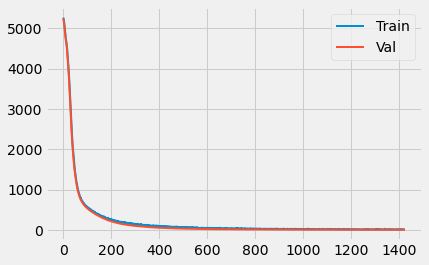

In [24]:
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

### 1.5 Evaluate

In [25]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
1/1 [==============================] - 0s 36ms/step - loss: 9.5849 - acc: 0.9982
Done.
Test loss: 9.584897994995117
Test accuracy: 0.9981536269187927


#### Exercise 1.4.1

Add one more hidden GAT layer, build, compile, train and evaluate the model.

In [ ]:
# Inputs
in_x = keras.Input(shape=(dataset[0].x.shape[1],))
in_a = keras.Input(shape=(dataset[0].a.shape[0],), sparse=True)

# Add dropout on features (but not adjacency matrix)
dropout_1 = keras.layers.Dropout(.1)(in_x)

# Add GAT layer
gat_layer_1 = spktrl.layers.GATConv(
    channels=16,
    attn_heads=8,
    concat_heads=True,
    dropout_rate=.05,
    activation='selu',
    kernel_initializer='lecun_normal'
)([dropout_1, in_a])

# Add dropout
dropout_2 = keras.layers.Dropout(.1)(gat_layer_1)



######## YOUR CODE STARTS HERE ########

# Add another GAT layer
gat_layer_2 = ...

# Add another dropout layer
dropout_3 = ...

######## YOUR CODE ENDS HERE ########


# Final GAT layer
gat_out = spktrl.layers.GATConv(
    channels=dataset[0].n_labels,
    attn_heads=8,
    concat_heads=False,
    dropout_rate=.05,
    activation='softmax'
)([dropout_3, in_a])

In [ ]:
# Enclose the layers in the model
model = keras.Model(inputs=[in_x, in_a], outputs=gat_out)

# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10000  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

# Compile the model
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=PATIENCE//2, min_lr=5e-6, factor=.9)
]



######## YOUR CODE STARTS HERE ########
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=...,
    epochs=EPOCHS,
    callbacks=...
)
######## YOUR CODE ENDS HERE ########

In [ ]:
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

In [ ]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

## 2. Graph classification with model sub-classing API

We'll use **Proteins** dataset, a part of [TU Datasets](https://chrsmrrs.github.io/datasets/).

Proteins dataset is stored in a **disjoint** format.



<img src="img/disjoint.png" width=400>


We'll need not only adjacency matrix and feature matrix, but also index matrix to identify which nodes belong to which batch.

### 2.1 Get the data

In [26]:
dataset = TUDataset("PROTEINS", clean=True)

Successfully loaded PROTEINS.


#### Exercise 2.1.1

Check how many nodes are in the 8th graph of **Proteins** dataset.

How many are there in 172nd?

In [27]:
# YOUR CODE HERE
dataset[7]

Graph(n_nodes=19, n_node_features=4, n_edge_features=None, n_labels=2)

### 2.2 Split + dataloaders

In [29]:
# Train / test split
idxs = np.random.permutation(len(dataset))  # Random split
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])

# Get train and test datsets
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

# Get loaders 
loader_tr = DisjointLoader(dataset_tr, batch_size=32, epochs=10)
loader_te = DisjointLoader(dataset_te, batch_size=32, epochs=1)

### 2.3 Define the model

In [30]:
class GCN(keras.models.Model):
    
    def __init__(self, channels, n_layers, dropout_rate=.2):
        
        super().__init__()
        
        self.conv1 = spktrl.layers.GCNConv(channels)
        self.convs = []
        
        for _ in range(1, n_layers):
            self.convs.append(
                spktrl.layers.GCNConv(channels)
            )
        self.pool = spktrl.layers.GlobalAvgPool()
        self.dense1 = keras.layers.Dense(channels, activation='relu')
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(dataset.n_labels, activation='softmax')

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

### 2.3 Compile, train & evaluate 

#### 2.3.1 Setup

In [31]:
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

In [32]:
# Instantiate the model
model = GCN(
    channels=16,
    dropout_rate=.1,
    n_layers=2
)

In [33]:
# Define the optimizer
optimizer = keras.optimizers.RMSprop(LR)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)


In [34]:
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_te.load(),
    validation_steps=loader_te.steps_per_epoch,
    epochs=EPOCHS
)

Epoch 1/10
 7/28 [======>.......................] - ETA: 0s - loss: 258.7665 - acc: 0.4866

C:\Users\aleks\anaconda3\envs\tf-spektral-minimal\lib\site-packages\spektral\data\utils.py:213: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


28/28 [==============================] - 5s 22ms/step - loss: 123.7635 - acc: 0.5576 - val_loss: 23.7878 - val_acc: 0.3367
Epoch 2/10
28/28 [==============================] - 1s 25ms/step - loss: 25.2934 - acc: 0.6237
Epoch 3/10
28/28 [==============================] - 0s 10ms/step - loss: 22.1513 - acc: 0.6556
Epoch 4/10
28/28 [==============================] - 0s 10ms/step - loss: 21.1284 - acc: 0.6340
Epoch 5/10
28/28 [==============================] - 0s 10ms/step - loss: 21.0358 - acc: 0.6465
Epoch 6/10
28/28 [==============================] - 0s 11ms/step - loss: 20.9220 - acc: 0.6465
Epoch 7/10
28/28 [==============================] - 0s 11ms/step - loss: 20.8778 - acc: 0.6465
Epoch 8/10
28/28 [==============================] - 0s 11ms/step - loss: 20.6952 - acc: 0.6465
Epoch 9/10
28/28 [==============================] - 0s 14ms/step - loss: 20.6270 - acc: 0.6465
Epoch 10/10
28/28 [==============================] - 0s 11ms/step - loss: 20.6415 - acc: 0.6465


#### Exercise 2.3.1

Train a GCN with:

* 32 channels 
* 6 layers
* Adam optimizer (use the same learning rate, `LR`)

Are the results better?

In [ ]:
# Get loaders 
loader_tr = DisjointLoader(dataset_tr, batch_size=32, epochs=10)
loader_te = DisjointLoader(dataset_te, batch_size=32, epochs=1)

######## YOUR CODE STARTS HERE ########
model = ...

# Define the optimizer
optimizer = ...

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_te.load(),
    validation_steps=loader_te.steps_per_epoch,
    epochs=EPOCHS
)

## 3. Building a custom dataset

To build your own dataset, you should store your data in a specific location. 

Locally it's: `~/.spektral/datasets/[ClassName]`

You can overwrite it by defining the `path` property of a `Dataset` class. 



Path on **Colab**: `/usr/local/lib/python3.7/dist-packages/spectral/datasets`


___________________________

<img src="img/tensorcell.png" width=150>

<br>

Now, we're going to look at a dataset class that we used in one of our experiments at [TensorCell](https://www.tensorcell.com/)




___________________________

In [ ]:
class TensorcellDataset(Dataset):
    
    """A Tensorcell dataset."""
    
    def __init__(self, dataset_variant, allow_self_loops=True, circular_mapping=False, add_constant_feature=False, add_one_hot_index=False, **kwargs):
        """
        :param dataset_variant: A dataset to pick. Currently takes: `ochota_100k`, `centrum_100k`, `mokotow_100k`
        :type dataset_variant: str
        :param circular_mapping: If node values should be mapped to a unit circle
        :type circular_dataset: bool

        ...
        :return: None
        :rtype: None
        """

        self.dataset_variant = dataset_variant
        self.allow_self_loops = allow_self_loops
        self.circular_mapping = circular_mapping
        self.add_constant_feature = add_constant_feature
        self.add_one_hot_index = add_one_hot_index
        
        # Construct filenames
        dataset_info = dataset_variant.split('_')
        district = dataset_info[0]
        n_rows = dataset_info[1]
        
        self.filename_A = f'{district}_A.txt'
        self.filename_Xy = f'{district}_X_{n_rows}.txt'

        super().__init__(**kwargs)


    def read(self):
        
        """
        :return: output
        :rtype: list
        """
        
        # We must return a list of Graph objects
        output = []
        
        # Read files
        adjacency_matrix = np.loadtxt(os.path.join(self.path, self.filename_A))
        features = np.loadtxt(os.path.join(self.path, self.filename_Xy), delimiter=',')

        # Add/remove self loops in the adjacency matrix
        if self.allow_self_loops:
            np.fill_diagonal(adjacency_matrix, 1)
        else:
            np.fill_diagonal(adjacency_matrix, 0)

        
        # Construct graph objects
        for row in range(features.shape[0]):

            # If `circular_mapping` -> map to a circular representation
            if self.circular_mapping:
                x = self.get_circular_components(features[row, :-1]).T
            else:
                x = features[row, :-1][:, np.newaxis]

            # Add constant feature 1
            if self.add_constant_feature:
                x = np.hstack([x, np.ones(x.shape[0])[:, np.newaxis]])

            # Add one-hot encoded node label
            if self.add_one_hot_index:

                x_plus_oh = []

                for i, d in enumerate(x):
                    one_hot_index = np.zeros(x.shape[0])
                    one_hot_index[i] = 1
                    x_plus_oh.append(np.hstack([d, one_hot_index]))

                x = np.array(x_plus_oh)

            # Construct a graph 
            output.append(
                Graph(
                    x=x, 
                    a=adjacency_matrix, 
                    y=features[row, -1])
            )

        return output

In [ ]:
dataset = TensorcellDataset('ochota_100k')